## All Imports and their reasons

In [169]:
# For downloading dataset
from urllib.request import urlretrieve
import os

# For extracting dataset
import tarfile

# For reading images
import cv2

# Essentials :)
import numpy as np

# pretty printing python objects
import pprint

# for sorting dictionary by value
import operator

# for showing images inline
from matplotlib.pyplot import imshow 
%matplotlib inline 

# for making labels one-hot encoded
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# for splitting data into training and validation data
from sklearn.model_selection import train_test_split

# for CNN and NN models
from keras.models import Sequential
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten

## Download the dataset to a folder inside this directory

In [10]:
URL_CALTECH_101_DATA = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'

def download_dataset(url):
    current_directory = os.path.dirname(os.path.realpath('__file__'))
    dataset_file_path = current_directory+"/dataset.tgz"
    if os.path.exists(dataset_file_path):
        print("Already downloaded.")
    else:
        filename, headers = urlretrieve(url, dataset_file_path)        
    print("Done")

download_dataset(URL_CALTECH_101_DATA)

Already downloaded.
Done


In [12]:
def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("Done")

extract_dataset('./dataset.tgz','./data/')

Done


## Exploring dataset

In [90]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [70]:
dolphin_imgs = get_images('dolphin','./data')

In [71]:
dolphin_imgs[0]

'./data/101_ObjectCategories/dolphin/image_0032.jpg'

In [79]:
dolphin_test_img = read_image(dolphin_imgs[0])

In [73]:
dolphin_test_img.shape

(200, 300, 3)

#### How many images we have for each category?

In [76]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [77]:
return_images_per_category('./data')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('trilobite', 86),
 ('kangaroo', 86),
 ('starfish', 86),
 ('buddha', 85),
 ('ewer', 85),
 ('sunflower', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('electric_guitar', 75),
 ('umbrella', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('dalmatian', 67),
 ('ferry', 67),
 ('flamingo', 67),
 ('dolphin', 66),
 ('lotus', 66),
 ('elephant', 64),
 ('joshua_tree', 64),
 ('soccer_ball', 64),
 ('stop_sign', 64),
 ('euphonium', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('wheelchair', 59),
 ('cellphone', 59),
 ('stegosaurus', 59)

In [78]:
len(return_images_per_category('./data'))

102

**The number of objects we need to classify is 101. So, we can actually ignore the BACKGROUND_Google directory**

## Creating Dataset for some ML

For machine learning, we need to convert the dataset into X and Y, wherein 

*X* would look something like **(num_of_total_images, ROWS, COLS, CHANNELS)** 

`The ROWS and COLS need to be fixed, however we have varied sized images. This is why the read_image method above resizes each image to 300x200 which is the average size of images (so most images wouldn't be affected).`

*Y* would be **(num_of_total_images, 1)**

**What's the total number of images we need in our dataset?**

In [80]:
total_count = 0
for category,count in return_images_per_category('./data'):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  8678


In [145]:
def create_training_data(data_directory):
    i = 0
    X = np.ndarray((8677, 200, 300, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X[i] = read_image(image)
            Y.insert(i,category) 
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [146]:
X, Y = create_training_data('./data')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

** Checking datasets sanity **

In [147]:
X.shape

(8677, 200, 300, 3)

Let's check a random example and see if its class matches or not

In [148]:
Y[2323]

'Faces_easy'

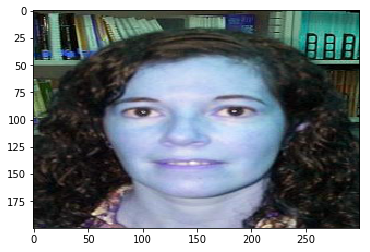

In [149]:
imshow(X[2323])

In [150]:
Y[1001]

'Motorbikes'

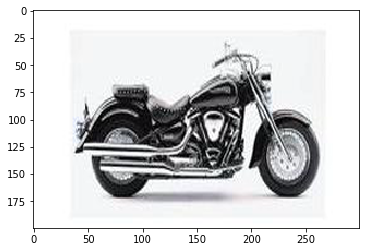

In [151]:
imshow(X[1001])

Seems all good. 

### Making one-hot encoded labels

In [152]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([ 5,  5,  5, ..., 52, 52, 52])

In [153]:
len(Y_integer_encoded)

8677

In [154]:
len(Y)

8677

In [155]:
len(X)

8677

Integers have ordering property which we don't want our ML models to learn since an apple isn't in any way greater than an airplane.
So, we must create a one-hot encoding. 

In [156]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [157]:
Y_one_hot[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [158]:
len(Y_one_hot[0])

101

To get back the label for any one-hot encoded label

In [159]:
label_encoder.inverse_transform(np.argmax(Y_one_hot[0]))

'airplanes'

### Splitting the Data

In [160]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y_one_hot, test_size=0.25, random_state=42)

In [161]:
X_train.shape

(6507, 200, 300, 3)

In [162]:
Y_train.shape

(6507, 101)

Sanity Check

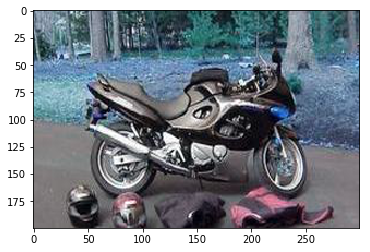

In [163]:
imshow(X_train[6001])

In [165]:
label_encoder.inverse_transform(np.argmax(Y_train[6001]))

'Motorbikes'

## Approach 1 - A Small CNN

**Defining Model Architecture**

In [176]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_cnn.add(Conv2D(32, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(Conv2D(128, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(101, activation='softmax'))
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 198, 298, 16)      448       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 196, 296, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 98, 148, 32)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 146, 64)       18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 94, 144, 128)      73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 47, 72, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 433152)            0         
__________

**Defining Loss and Optimizer**

In [177]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [178]:
model_cnn.fit(X_train, Y_train, batch_size=128, epochs=30, verbose=1, validation_data=(X_validation,Y_validation))

Train on 6507 samples, validate on 2170 samples
Epoch 1/30


KeyboardInterrupt: 